In [1]:
import warnings; warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
import numpy as np
import pandas as pd
pd.options.display.float_format = ' {:.3f}' .format
pd.options.display.max_columns = 200
#         .         .         .         .         .         .         .         .         .         .         .         .
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

In [3]:
def logistic(x, Emax, EC50, Hill_slope):      # Logistic function to simulate dose-response.
    return Emax / (1 + (x / EC50)**(-Hill_slope))

In [4]:
# Parameters for simulation
# Maximum response, EC50 (half-maximal concentration), Hill slope (Steepness of the curve)
Emax_1 = 100 ; EC50_1 = 1.0 ; Hill_slope_1  = 1.2
Emax_2 = 100 ; EC50_2 = 1.2 ; Hill_slope_2  = 3 

#Standard deviation of random noise, Noise level for high concentrations, Noise level for low concentrations
low_mid_threshold  = 0.5; high_mid_threshold = 2.0

low_noise_1   = 1  ;  mid_noise_1 = 6  ;  high_noise_1  = 1
low_noise_2   = 6  ;  mid_noise_2 = 5  ;  high_noise_2  = 6

# Simulated concentrations (log-spaced)
concentrations_1 = np.logspace(-2, 2, 16)  # From 0.01 to 100 (log scale)
concentrations_2 = np.logspace(-2, 2, 16)  # From 0.01 to 100 (log scale)

# Calculate the 95% confidence intervals for each concentration (mean ± 1.96 * std deviation)
confidence_level = 1.96  # for 95% CI

In [5]:
# Simulate true responses (without noise)
response_1 = logistic(concentrations_1, Emax_1, EC50_1, Hill_slope_1)
response_2 = logistic(concentrations_2, Emax_2, EC50_2, Hill_slope_2)

In [6]:
# Function to adjust noise based on concentration
def adjust_noise(concentrations, low_noise, high_noise, mid_noise, 
                 low_mid_threshold=low_mid_threshold, high_mid_threshold=high_mid_threshold):
    noise_factor = np.where(concentrations < low_mid_threshold, low_noise, 
                            np.where(concentrations > high_mid_threshold, high_noise, mid_noise))
    return noise_factor

In [7]:
# Apply varying noise levels at different concentrations for triplicates
noise_factor_1 = adjust_noise(concentrations_1, low_noise_1, high_noise_1, mid_noise_1)
noise_factor_2 = adjust_noise(concentrations_2, low_noise_2, high_noise_2, mid_noise_2)

In [8]:
# Simulate triplicates with varying noise for each treatment (y-values)
triplicates_1 = [response_1 + np.random.normal(0, noise_factor_1, size=response_1.size) for _ in range(3)]
triplicates_2 = [response_2 + np.random.normal(0, noise_factor_2, size=response_2.size) for _ in range(3)]

In [9]:
# Create a DataFrame
data_1 = {'Concentration': concentrations_1, 'Y1': triplicates_1[0], 'Y2': triplicates_1[1], 'Y3': triplicates_1[2]}
data_2 = {'Concentration': concentrations_2, 'Y1': triplicates_2[0], 'Y2': triplicates_2[1], 'Y3': triplicates_2[2]}
df_1 = pd.DataFrame(data_1); df_2 = pd.DataFrame(data_2)

In [10]:
# Calculate mean and standard deviation for triplicates
df_1['Mean Response'] = df_1[['Y1', 'Y2', 'Y3']].mean(axis=1)
df_1['Std Deviation'] = df_1[['Y1', 'Y2', 'Y3']].std(axis=1)

df_2['Mean Response'] = df_2[['Y1', 'Y2', 'Y3']].mean(axis=1)
df_2['Std Deviation'] = df_2[['Y1', 'Y2', 'Y3']].std(axis=1)

In [11]:
# Calculate the upper and lower bounds for the confidence interval
df_1['CI Upper'] = df_1['Mean Response'] + confidence_level * df_1['Std Deviation']
df_1['CI Lower'] = df_1['Mean Response'] - confidence_level * df_1['Std Deviation']

df_2['CI Upper'] = df_2['Mean Response'] + confidence_level * df_2['Std Deviation']
df_2['CI Lower'] = df_2['Mean Response'] - confidence_level * df_2['Std Deviation']

In [12]:
#df_1.to_csv('output1.csv', index=False, float_format='%.3f')
#df_1 = pd.read_csv('output1.csv')
#df_2.to_csv('output2.csv', index=False, float_format='%.3f'); df_2 = pd.read_csv('output2.csv')

In [13]:
df_1.head(3)

,Concentration,Y1,Y2,Y3,Mean Response,Std Deviation,CI Upper,CI Lower
0,0.010,0.166,2.213,0.360,0.913,1.130,3.128,-1.302
1,0.018,0.710,1.731,1.776,1.406,0.603,2.587,0.224
2,0.034,-0.213,3.228,1.893,1.636,1.735,5.036,-1.764


In [14]:
df_2.head(3)

,Concentration,Y1,Y2,Y3,Mean Response,Std Deviation,CI Upper,CI Lower
0,0.010,5.695,-9.036,-10.461,-4.601,8.945,12.931,-22.133
1,0.018,-9.081,-3.960,-1.887,-4.976,3.703,2.282,-12.233
2,0.034,1.946,-4.251,7.643,1.779,5.949,13.439,-9.881


In [ ]:
auc1 = np.trapz(data_01['date_numeric'], data_01['close_norm']); print(f"AUC of Curve 1({symbol_01}): {auc1:.2f}")
auc2 = np.trapz(data_02['date_numeric'], data_02['close_norm']); print(f"AUC of Curve 2({symbol_02}): {auc2:.2f}")

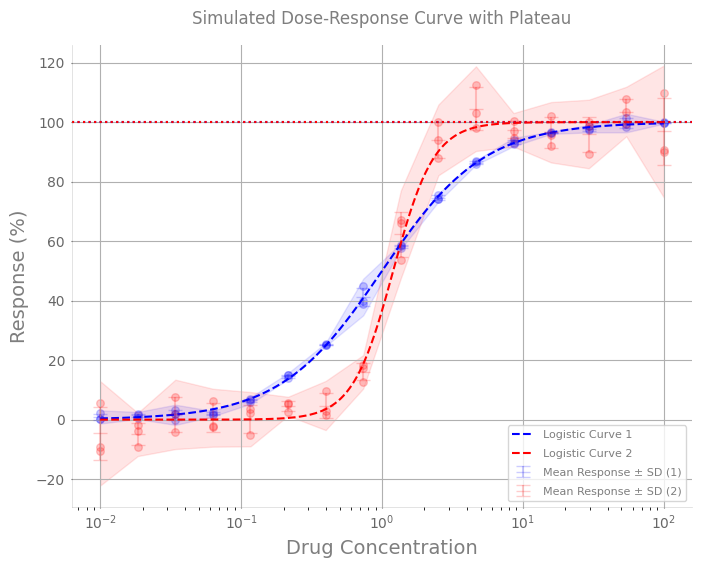

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
#         .         .         .         .         .         .         .         .         .         .         .         .
for i in range(3):
    plt.scatter(concentrations_1, df_1[f'Y{i+1}'], s=30, alpha=0.2, color='blue')
    plt.scatter(concentrations_2, df_2[f'Y{i+1}'], s=30, alpha=0.2, color='red')
#         .         .         .         .         .         .         .         .         .         .         .         .
# Plot the mean response with error bars
error_kws = {'fmt':'o', 'marker':'_', 'markersize':10,  'alpha':0.2, 'capsize':5}
plt.errorbar(df_1['Concentration'], df_1['Mean Response'], yerr=df_1['Std Deviation'], label='Mean Response ± SD (1)', color='blue', **error_kws)
plt.errorbar(df_2['Concentration'], df_2['Mean Response'], yerr=df_2['Std Deviation'], label='Mean Response ± SD (2)', color='red', **error_kws)
#         .         .         .         .         .         .         .         .         .         .         .         .
# Plot the true logistic curve
x_smooth_1 = np.logspace(np.log10(min(concentrations_1)), np.log10(max(concentrations_1)), 500)
x_smooth_2 = np.logspace(np.log10(min(concentrations_2)), np.log10(max(concentrations_2)), 500)
y_smooth_1 = logistic(x_smooth_1, Emax_1, EC50_1, Hill_slope_1)
y_smooth_2 = logistic(x_smooth_2, Emax_2, EC50_2, Hill_slope_2)
#         .         .         .         .         .         .         .         .         .         .         .         .
plt.plot(x_smooth_1, y_smooth_1, label='Logistic Curve 1', color='blue', linestyle='--')
plt.plot(x_smooth_2, y_smooth_2, label='Logistic Curve 2', color='red',  linestyle='--')
#         .         .         .         .         .         .         .         .         .         .         .         .
# Plot confidence interval as shaded area (95% CI)
plt.fill_between(df_1['Concentration'], df_1['CI Lower'], df_1['CI Upper'], color='blue', alpha=0.1, label=None)
plt.fill_between(df_2['Concentration'], df_2['CI Lower'], df_2['CI Upper'], color='red',  alpha=0.1, label=None)
#         .         .         .         .         .         .         .         .         .         .         .         .
plt.axhline(Emax_1, color='blue', linestyle=':', label=None)
plt.axhline(Emax_2, color='red',  linestyle=':', label=None)
#         .         .         .         .         .         .         .         .         .         .         .         .
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False); 
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color('#7E7E7E'); ax.spines[spine].set_alpha(0.3); ax.spines[spine].set_linewidth(0.5)
#         .         .         .         .         .         .         .         .         .         .         .         .
plt.xscale('log')  # Logarithmic scale for concentrations
plt.xlabel('Drug Concentration', fontsize=14, color="#7E7E7E", labelpad=5)
plt.ylabel('Response (%)',       fontsize=14, color="#7E7E7E", labelpad=5)
#         .         .         .         .         .         .         .         .         .         .         .         .
tickp_kws = {'labelsize': 10, 'colors': "#676767", 'pad': 4, 'length': 1}
ax.tick_params(axis="x", **tickp_kws)
ax.tick_params(axis="y", which='major', **tickp_kws)
#         .         .         .         .         .         .         .         .         .         .         .         .
plt.title('Simulated Dose-Response Curve with Plateau', fontsize=12, color="#7E7E7E", pad=15)

plt.legend()
ax.legend(fontsize=8, loc='best', frameon=True, title=None, title_fontsize=0, labelspacing=0.8, labelcolor='#7E7E7E', borderaxespad=0.1)
plt.legend([],[],frameon=False)
#         .         .         .         .         .         .         .         .         .         .         .         .

plt.grid(True)
plt.show()

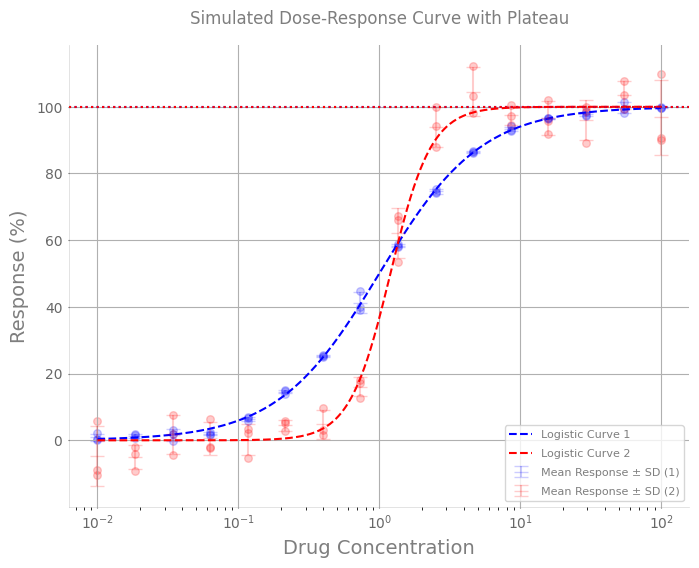

In [16]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plots for individual responses
for i in range(3):
    plt.scatter(concentrations_1, df_1[f'Y{i+1}'], s=30, alpha=0.2, color='blue')
    plt.scatter(concentrations_2, df_2[f'Y{i+1}'], s=30, alpha=0.2, color='red')

# Plot the mean response with error bars
error_kws = {'fmt': 'o', 'marker': '_', 'markersize': 10, 'alpha': 0.2, 'capsize': 5}
plt.errorbar(df_1['Concentration'], df_1['Mean Response'], yerr=df_1['Std Deviation'],
             label='Mean Response ± SD (1)', color='blue', **error_kws)
plt.errorbar(df_2['Concentration'], df_2['Mean Response'], yerr=df_2['Std Deviation'],
             label='Mean Response ± SD (2)', color='red', **error_kws)

# Smooth x-values for logistic curves and CI bands
x_smooth_1 = np.logspace(np.log10(min(concentrations_1)), np.log10(max(concentrations_1)), 500)
x_smooth_2 = np.logspace(np.log10(min(concentrations_2)), np.log10(max(concentrations_2)), 500)

# True logistic curve
y_smooth_1 = logistic(x_smooth_1, Emax_1, EC50_1, Hill_slope_1)
y_smooth_2 = logistic(x_smooth_2, Emax_2, EC50_2, Hill_slope_2)
plt.plot(x_smooth_1, y_smooth_1, label='Logistic Curve 1', color='blue', linestyle='--')
plt.plot(x_smooth_2, y_smooth_2, label='Logistic Curve 2', color='red', linestyle='--')

# Interpolate CI for Group 1
ci_lower_interp_1 = interp1d(df_1['Concentration'], df_1['CI Lower'], kind='cubic')
ci_upper_interp_1 = interp1d(df_1['Concentration'], df_1['CI Upper'], kind='cubic')
ci_lower_smooth_1 = ci_lower_interp_1(x_smooth_1)
ci_upper_smooth_1 = ci_upper_interp_1(x_smooth_1)

# Interpolate CI for Group 2
ci_lower_interp_2 = interp1d(df_2['Concentration'], df_2['CI Lower'], kind='linear') #cubic
ci_upper_interp_2 = interp1d(df_2['Concentration'], df_2['CI Upper'], kind='linear')
ci_lower_smooth_2 = ci_lower_interp_2(x_smooth_2)
ci_upper_smooth_2 = ci_upper_interp_2(x_smooth_2)

# Plot smooth confidence intervals as shaded areas
#plt.fill_between(x_smooth_1, ci_lower_smooth_1, ci_upper_smooth_1, color='blue', alpha=0.1, label=None)
#plt.fill_between(x_smooth_2, ci_lower_smooth_2, ci_upper_smooth_2, color='red',  alpha=0.1, label=None)

# Horizontal lines for Emax
plt.axhline(Emax_1, color='blue', linestyle=':', label=None)
plt.axhline(Emax_2, color='red' , linestyle=':', label=None)

# Customizing axes
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
for spine in ['left', 'bottom']:
    ax.spines[spine].set_color('#7E7E7E')
    ax.spines[spine].set_alpha(0.3)
    ax.spines[spine].set_linewidth(0.5)

plt.xscale('log')     # Logarithmic scale for concentrations
plt.xlabel('Drug Concentration', fontsize=14, color="#7E7E7E", labelpad=5)
plt.ylabel('Response (%)', fontsize=14, color="#7E7E7E", labelpad=5)

tickp_kws = {'labelsize': 10, 'colors': "#676767", 'pad': 4, 'length': 1}
ax.tick_params(axis="x", **tickp_kws)
ax.tick_params(axis="y", which='major', **tickp_kws)

plt.title('Simulated Dose-Response Curve with Plateau', fontsize=12, color="#7E7E7E", pad=15)
plt.legend()
ax.legend(fontsize=8, loc='best', frameon=True, labelspacing=0.8, labelcolor='#7E7E7E')

plt.grid(True); plt.show()

In [17]:
# Fit the logistic function to the data and return the parameters (Emax, EC50, Hill_slope)
def fit_logistic(concentrations, responses): 
    popt, _ = curve_fit(logistic, concentrations, responses, p0=[max(responses), 10, 1])
    return popt

In [18]:
# Fit both treatments
params_1 = fit_logistic(concentrations_1, df_1[['Y1', 'Y2', 'Y3']].mean(axis=1))
params_2 = fit_logistic(concentrations_2, df_2[['Y1', 'Y2', 'Y3']].mean(axis=1))

Emax_1, EC50_1_est, Hill_slope_1_est = params_1
Emax_2, EC50_2_est, Hill_slope_2_est = params_2

print(f"Estimated EC50 for Treatment 1: {EC50_1_est:.2f}")
print(f"Estimated EC50 for Treatment 2: {EC50_2_est:.2f}")

Estimated EC50 for Treatment 1: 1.01
Estimated EC50 for Treatment 2: 1.17


In [19]:
# Statistical test to compare EC50 values
# You can calculate the p-value comparing the two EC50 estimates directly or use bootstrapping
# For simplicity, here we'll use a basic t-test for EC50 differences
# Assume you have some replicate EC50 estimates or samples (e.g., by bootstrapping or resampling)

# For simplicity, we're assuming EC50 values follow normal distributions for this example
# Simulate some "replicates" of EC50 values by adding random noise around the estimates
np.random.seed(42)
ec50_1_replicates = np.random.normal(EC50_1_est, 0.5, size=100)  # Simulate 100 replicates for Treatment 1
ec50_2_replicates = np.random.normal(EC50_2_est, 0.5, size=100)  # Simulate 100 replicates for Treatment 2

# Perform a t-test to compare the EC50 distributions
t_stat, p_val = ttest_ind(ec50_1_replicates, ec50_2_replicates)

print(f"\nStatistical comparison between EC50 values:")
print(f"T-statistic:\t{t_stat:.4f}")
print(f"P-value:\t {p_val:.4f}")


Statistical comparison between EC50 values:
T-statistic:	-3.3667
P-value:	 0.0009
